In [1]:
import pandas as pd
from IPython.display import display
import os
import random
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
import glob
import matplotlib.pyplot as plt
import re



## Raw data preprocessing

In [125]:
def process_dataframe(file_path):
    # Read the Excel file
    df_cleaned = pd.read_excel(file_path)

    # Fill missing values based on time
    def fill_missing_values_based_on_time(dataframe):
        dataframe['rawtime'] = pd.to_datetime(dataframe['rawtime'])
        for index, row in dataframe.iterrows():
            if row.isnull().any():
                prev_row = dataframe.iloc[index - 1] if index - 1 >= 0 else None
                next_row = dataframe.iloc[index + 1] if index + 1 < len(dataframe) else None
                for col in dataframe.columns:
                    if pd.isnull(row[col]):
                        if prev_row is not None and next_row is not None:
                            prev_diff = abs(row['rawtime'] - prev_row['rawtime'])
                            next_diff = abs(row['rawtime'] - next_row['rawtime'])
                            if prev_diff < next_diff:
                                dataframe.at[index, col] = prev_row[col]
                            else:
                                dataframe.at[index, col] = next_row[col]
                        elif prev_row is not None:
                            dataframe.at[index, col] = prev_row[col]
                        elif next_row is not None:
                            dataframe.at[index, col] = next_row[col]
        return dataframe

    df_filled = fill_missing_values_based_on_time(df_cleaned)

    # Convert rawtime to "YYYY-MM-DD HH:MM" format
    df_filled['rawtime'] = df_filled['rawtime'].dt.strftime('%Y-%m-%d %H:%M')

    # Check for duplicate timestamps
    def check_duplicate_timestamps(dataframe):
        duplicate_counts = dataframe['rawtime'].value_counts()
        duplicates = duplicate_counts[duplicate_counts > 1]
        if not duplicates.empty:
            print(f"There are {duplicates.sum()} duplicate timestamps. The first duplicate value will be removed.")
        return duplicates

    duplicates_info = check_duplicate_timestamps(df_filled)

    # Remove the first occurrence of duplicate timestamps
    def remove_first_duplicate_and_recheck(dataframe):
        duplicate_timestamps = dataframe['rawtime'][dataframe['rawtime'].duplicated(keep='first')]
        dataframe_cleaned = dataframe.drop(duplicate_timestamps.index)
        duplicate_counts = dataframe_cleaned['rawtime'].value_counts()
        duplicates_after_removal = duplicate_counts[duplicate_counts > 1]
        if duplicates_after_removal.empty:
            print("Processing complete, no duplicate timestamps remain.")
        else:
            print(f"There are still {duplicates_after_removal.sum()} duplicate timestamps remaining.")
        return dataframe_cleaned

    df_cleaned_final = remove_first_duplicate_and_recheck(df_filled)

    # Insert missing rows with ID as the first column
    def insert_missing_rows_with_id_first(dataframe):
        dataframe['rawtime'] = pd.to_datetime(dataframe['rawtime'])
        full_time_range = pd.date_range(start=dataframe['rawtime'].min(), end=dataframe['rawtime'].max(), freq='T')
        df_full = pd.DataFrame({'rawtime': full_time_range})
        df_merged = pd.merge(df_full, dataframe, on='rawtime', how='left')
        df_merged['ID'] = dataframe['ID'].iloc[0]
        df_merged['rawtime'] = df_merged['rawtime'].dt.strftime('%Y-%m-%d %H:%M')
        columns_order = ['ID', 'rawtime'] + [col for col in df_merged.columns if col not in ['ID', 'rawtime']]
        return df_merged[columns_order]

    df_with_inserted_rows = insert_missing_rows_with_id_first(df_cleaned_final)

    # Fill the 'Operational_status' column with the previous value
    def fill_previous_value_for_column(dataframe, column_name):
        dataframe[column_name] = dataframe[column_name].fillna(method='ffill')
        return dataframe

    df_filled_with_previous = fill_previous_value_for_column(df_with_inserted_rows, 'Operational_status')
    df_filled_with_previous = fill_previous_value_for_column(df_with_inserted_rows, 'City')
    df_filled_with_previous = fill_previous_value_for_column(df_with_inserted_rows, 'Mode')
    # Interpolate 'Tin' and 'Tout' and round to 1 decimal place
    def fill_with_interpolation_and_rounding(dataframe, columns, decimal_places=1):
        dataframe[columns] = dataframe[columns].interpolate(method='linear', limit_direction='both').round(decimal_places)
        return dataframe

    df_filled_with_rounded_interpolation = fill_with_interpolation_and_rounding(df_filled_with_previous, ['Tin', 'Tout'], decimal_places=1)

    # Fill 'Setpoint' column with the previous value
    df_filled_with_final_adjustments = fill_previous_value_for_column(df_filled_with_rounded_interpolation, 'Setpoint')

    # Function to count the number of shutdown cycles
    def count_shutdown_cycles(dataframe, column_name):
        shutdown_cycles = 0
        in_shutdown = False
    
        for i in range(len(dataframe)):
            current_status = dataframe.iloc[i][column_name]
            if current_status == 0 and not in_shutdown:
                in_shutdown = True  # Start of a shutdown cycle
            elif current_status == 1 and in_shutdown:
                shutdown_cycles += 1  # End of a shutdown cycle
                in_shutdown = False  # Reset for the next cycle   
        return shutdown_cycles
    # Apply the function to count shutdown cycles in 'Operational_status'
    shutdown_cycles_count = count_shutdown_cycles(df_filled_with_final_adjustments, 'Operational_status')
    
    # Display the result
    print(f"There are {shutdown_cycles_count} shutdown cycles.")

    # Function to replace temperature values with 'no_records' for each shutdown cycle
    def replace_temperatures_in_shutdown_cycles(dataframe, column_name, temperature_columns):
        in_shutdown = False
        shutdown_start = None
    
        for i in range(len(dataframe)):
            current_status = dataframe.iloc[i][column_name]
        
            if current_status == 0 and not in_shutdown:
                # Mark the start of the shutdown cycle
                in_shutdown = True
                shutdown_start = i
            elif current_status == 1 and in_shutdown:
                # End of the shutdown cycle, process the rows
                if shutdown_start is not None and (i - shutdown_start) > 1:
                    # Replace values from the second 'Operational_status' == 0 until the last one
                    dataframe.loc[shutdown_start + 1:i - 1, temperature_columns] = 'no_records'
                # Reset for the next cycle
                in_shutdown = False
                shutdown_start = None

        return dataframe
    temperature_columns_to_replace = ['Setpoint', 'Tin', 'Tout']
    df_replaced_temperatures = replace_temperatures_in_shutdown_cycles(df_filled_with_final_adjustments, 'Operational_status', temperature_columns_to_replace)

    # Add the "On/Off action" column
    def add_switch_action_column(dataframe, status_column):
        dataframe['On/OFF'] = ''
        for i in range(len(dataframe) - 1):
            current_status = dataframe.iloc[i][status_column]
            next_status = dataframe.iloc[i + 1][status_column]
            if current_status == 0 and next_status == 1:
                dataframe.at[i + 1, 'On/OFF'] = 'ON'
            elif current_status == 1 and next_status == 0:
                dataframe.at[i + 1, 'On/OFF'] = 'OFF'
        return dataframe

    df_with_switch_action = add_switch_action_column(df_replaced_temperatures, 'Operational_status')

    # Add the "Setpoint adjustment" column
    def add_temperature_action_column_with_handling(dataframe, temp_column):
        dataframe['Setpoint adjustment'] = ''
        for i in range(len(dataframe) - 1):
            current_temp = dataframe.iloc[i][temp_column]
            next_temp = dataframe.iloc[i + 1][temp_column]
            if pd.api.types.is_numeric_dtype(type(current_temp)) and pd.api.types.is_numeric_dtype(type(next_temp)):
                if next_temp > current_temp:
                    dataframe.at[i + 1, 'Setpoint adjustment'] = 'Upper'
                elif next_temp < current_temp:
                    dataframe.at[i + 1, 'Setpoint adjustment'] = 'Lower'
        return dataframe

    df_final = add_temperature_action_column_with_handling(df_with_switch_action, 'Setpoint')

    # Display the final dataframe
    display(df_final)

    return df_final


In [7]:
df_final=process_dataframe("83562883812609_example.xlsx")

There are 540 duplicate timestamps. The first duplicate value will be removed.
Processing complete, no duplicate timestamps remain.
There are 291 shutdown cycles.


,ID,rawtime,City,Operational_status,Mode,Setpoint,Tin,Tout,On/OFF,Setpoint adjustment
0,83562883812609,2020-05-13 15:11,Shanghai,1.0,2.0,26.0,24.2,24.0,,
1,83562883812609,2020-05-13 15:12,Shanghai,1.0,2.0,23.0,24.2,24.0,,Lower
2,83562883812609,2020-05-13 15:13,Shanghai,1.0,2.0,23.0,24.0,24.1,,
3,83562883812609,2020-05-13 15:14,Shanghai,1.0,2.0,23.0,23.9,24.1,,
4,83562883812609,2020-05-13 15:15,Shanghai,1.0,2.0,23.0,23.7,24.2,,
...,...,...,...,...,...,...,...,...,...,...
210114,83562883812609,2020-10-06 13:05,Shanghai,1.0,2.0,22.0,23.3,26.3,,
210115,83562883812609,2020-10-06 13:06,Shanghai,1.0,2.0,22.0,23.3,26.4,,
210116,83562883812609,2020-10-06 13:07,Shanghai,1.0,2.0,22.0,23.3,26.4,,
210117,83562883812609,2020-10-06 13:08,Shanghai,1.0,2.0,22.0,23.3,26.5,,


## Usage scenario analysis

In [126]:
def process_ac_data(data):
    # Convert rawtime to datetime format
    data['rawtime'] = pd.to_datetime(data['rawtime'])

    # Group by hour, calculating the total minutes each air conditioner was on per hour
    data['hour'] = data['rawtime'].dt.floor('H')
    hourly_data = data.groupby(['ID', 'hour'])['Operational_status'].sum().reset_index()
    hourly_data['Operational_status'] = hourly_data['Operational_status'].clip(upper=60)

    # Define the night and day hours
    night_hours = [22, 23, 0, 1, 2, 3, 4, 5, 6, 7]
    day_hours = list(set(range(24)) - set(night_hours))
    hourly_data['hour_of_day'] = hourly_data['hour'].dt.hour

    # Calculate the night-time and day-time usage duration for each air conditioner
    night_usage = hourly_data[hourly_data['hour_of_day'].isin(night_hours)].groupby('ID')['Operational_status'].sum().reset_index()
    night_usage.rename(columns={'Operational_status': 'night_usage'}, inplace=True)

    day_usage = hourly_data[hourly_data['hour_of_day'].isin(day_hours)].groupby('ID')['Operational_status'].sum().reset_index()
    day_usage.rename(columns={'Operational_status': 'day_usage'}, inplace=True)

    # Summarize the total minutes of operation per air conditioner for each hour
    hourly_usage = hourly_data.groupby(['ID', 'hour_of_day'])['Operational_status'].sum().unstack(fill_value=0)
    hourly_usage.columns = [f'hour_{int(col)}_total_minutes' for col in hourly_usage.columns]

    # Calculate the total operation minutes for 24 hours
    hourly_usage['total_24h_minutes'] = hourly_usage.sum(axis=1)

    # Calculate the hourly usage probability, i.e., the proportion of total operation minutes for each hour
    hourly_usage_prob = hourly_usage.div(hourly_usage['total_24h_minutes'], axis=0)
    hourly_usage_prob.drop(columns=['total_24h_minutes'], inplace=True)
    hourly_usage_prob.columns = [f'hour_{int(col)}_prob' for col in range(24)]

    # Calculate the average usage probability for day hours and night hours
    hourly_usage_prob['day_avg_prob'] = hourly_usage_prob[[f'hour_{h}_prob' for h in day_hours]].mean(axis=1)
    hourly_usage_prob['night_avg_prob'] = hourly_usage_prob[[f'hour_{h}_prob' for h in night_hours]].mean(axis=1)

    # Merge night and day usage data, along with the hourly usage probabilities
    summary = pd.merge(night_usage, day_usage, on='ID')
    summary = pd.merge(summary, hourly_usage_prob, on='ID')

    # Calculate the ratio of day usage to night usage
    summary['day/night ratio'] = summary['day_usage'] / (summary['night_usage'] + 1e-10)
    
    # Calculate the ratio of day usage to total usage (day + night)
    summary['day ratio'] = summary['day_usage'] / (summary['night_usage'] + summary['day_usage'] + 1e-10)
    
    # Calculate the ratio of night usage to total usage (day + night)
    summary['night ratio'] = summary['night_usage'] / (summary['night_usage'] + summary['day_usage'] + 1e-10)

    return summary


In [129]:
clusterexample=process_ac_data(df_final) #example

In [130]:
import joblib
import pandas as pd

def load_models():
    """
    Load the saved clustering models.
    
    Returns:
    - kmeans_model: The primary clustering model.
    - kmeans_recluster_model: The secondary clustering model.
    """
    kmeans_model = joblib.load('kmeans_model.pkl')
    kmeans_recluster_model = joblib.load('kmeans_recluster_model.pkl')
    return kmeans_model, kmeans_recluster_model

def predict_new_data(new_data, kmeans_model, kmeans_recluster_model):
    """
    Make predictions on new data and perform secondary clustering.
    
    Parameters:
    - new_data: The new data (a DataFrame containing hourly usage probabilities).
    - kmeans_model: The pre-trained primary clustering model.
    - kmeans_recluster_model: The pre-trained secondary clustering model.
    
    Returns:
    - final_label: The final classification label (e.g., 'Bedroom', 'Livingroom', 'Mixedroom', 'work', 'nonwork').
    """
    # Ensure new_data is a DataFrame and contains columns 'hour_0_prob' to 'hour_23_prob'
    probability_features = [f'hour_{i}_prob' for i in range(24)]
    
    if not all(col in new_data.columns for col in probability_features):
        raise ValueError("new_data DataFrame must contain columns: " + ", ".join(probability_features))
    
    # Predict using the primary clustering model
    cluster_label = kmeans_model.predict(new_data[probability_features])[0]
    cluster_labels = {0: 'Bedroom', 1: 'Livingroom', 2: 'Mixedroom'}
    cluster_name = cluster_labels[cluster_label]

    # Perform secondary clustering based on the initial cluster result
    if cluster_name == 'Livingroom':
        recluster_label = kmeans_recluster_model.predict(new_data[probability_features])[0]
        recluster_labels = {0: 'nonwork', 1: 'work'}
    elif cluster_name == 'Mixedroom':
        recluster_label = kmeans_recluster_model.predict(new_data[probability_features])[0]
        recluster_labels = {0: 'work', 1: 'nonwork'}
    else:
        recluster_label = None
        recluster_labels = None

    # Generate the final label
    final_label = f'{cluster_name} - {recluster_labels.get(recluster_label, "")}' if recluster_label is not None else cluster_name
    return final_label

# 1. Load the models
kmeans_model, kmeans_recluster_model = load_models()

# 2. Prepare the new data (replace `clusterexample` with the actual data you want to predict)
# You can read this data from an Excel file or manually create a DataFrame
new_data = clusterexample

# 3. Make predictions on the new data
final_label = predict_new_data(new_data, kmeans_model, kmeans_recluster_model)
print(f'Predicted label for the new data: {final_label}')


Predicted label for the new data: Mixedroom - work


## Comfort indoor air temperature model

Processing Mixedroom data for ID 83562883812609 example...
Saved plot to /Volumes/T7Shield/passport备份/论文夹/paper 9 个体空调/新建文件夹/修改/oneearth/example/83562883812609 example_regression_plot.png


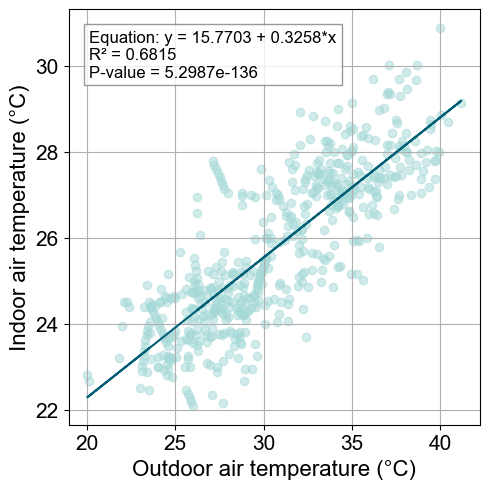

In [33]:
# Function to mark stable and sleep periods
def mark_stable_and_sleep_periods(df, state_col='Operational_status', temp_col='Setpoint', time_col='rawtime', 
                                  stable_col='Stable_period?', sleep_col='Sleep_period?'):
    df[stable_col] = 0
    df['Stable_period'] = (df[state_col] == 1) & (df[temp_col] == df[temp_col].shift(1))
    df['Stable_period'] = df['Stable_period'].astype(int).cumsum() - df['Stable_period'].astype(int).cumsum().where(
        ~df['Stable_period'].astype(bool)).ffill().fillna(0)
    df[stable_col] = (df['Stable_period'] >= 15).astype(int)
    df.drop(columns=['Stable_period'], inplace=True)
    df[sleep_col] = 0
    df[time_col] = pd.to_datetime(df[time_col])
    df['hour_minute'] = df[time_col].dt.time
    sleep_start = pd.to_datetime('22:00').time()
    sleep_end = pd.to_datetime('08:00').time()
    df[sleep_col] = df['hour_minute'].apply(lambda x: 1 if (x >= sleep_start or x < sleep_end) else 0)
    df.drop(columns=['hour_minute'], inplace=True)
    return df

# Function to extract hourly averages during non-sleep periods
def extract_and_average_stable_data(df, stable_col='Stable_period?', sleep_col='Sleep_period?', time_col='rawtime', 
                                    target_cols=None):
    if target_cols is None:
        target_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    stable_non_sleep_data = df[(df[stable_col] == 1) & (df[sleep_col] == 0)].copy()
    stable_non_sleep_data[time_col] = pd.to_datetime(stable_non_sleep_data[time_col])
    stable_non_sleep_data['hour'] = stable_non_sleep_data[time_col].dt.floor('H')
    hourly_avg = stable_non_sleep_data.groupby('hour')[target_cols].mean().reset_index()
    return hourly_avg

# Function to extract hourly averages during sleep periods
def extract_sleep_and_average_stable_data(df, state_col='Operational_status', sleep_col='Sleep_period?', 
                                          time_col='rawtime', target_cols=None):
    if target_cols is None:
        target_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    stable_sleep_data = df[(df[state_col] == 1) & (df[sleep_col] == 1)].copy()
    stable_sleep_data[time_col] = pd.to_datetime(stable_sleep_data[time_col])
    stable_sleep_data['hour'] = stable_sleep_data[time_col].dt.floor('H')
    hourly_avg = stable_sleep_data.groupby('hour')[target_cols].mean().reset_index()
    return hourly_avg

# Function to perform linear regression and plot results
def perform_linear_regression_and_plot(df, save_path, indoor_temp_col='Tin', outdoor_temp_col='Tout', device_id='ID'):
    # Extract independent and dependent variables
    X = df[outdoor_temp_col]
    y = df[indoor_temp_col]
    
    # Add a constant for the intercept
    X = sm.add_constant(X)
    
    # Perform linear regression
    model = sm.OLS(y, X).fit()
    r_squared = model.rsquared
    p_value = model.f_pvalue
    
    # Get regression coefficients
    intercept = model.params['const']
    slope = model.params[outdoor_temp_col]
    equation = f"y = {intercept:.4f} + {slope:.4f}*x"
    
    # Create a results DataFrame
    results_df = pd.DataFrame({
        'ID': [device_id],
        'R²': [r_squared],
        'p value': [p_value],
        'regression equation': [equation]
    })
    
    # Plotting
    plt.figure(figsize=(5, 5))
    plt.scatter(df[outdoor_temp_col], df[indoor_temp_col], label='Data Points', color='#A4D9D7', alpha=0.5)
    plt.plot(df[outdoor_temp_col], intercept + slope * df[outdoor_temp_col], color='#025F76', label='Regression Line')
    
    # Customize plot with Arial font and larger labels
    plt.xlabel('Outdoor air temperature (°C)', fontsize=16, fontname='Arial')
    plt.ylabel('Indoor air temperature (°C)', fontsize=16, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
    plt.grid(True)
    
    # Display regression equation, R², and p-value on the plot
    plt.text(
        0.05, 0.95, 
        f"Equation: {equation}\nR² = {r_squared:.4f}\nP-value = {p_value:.4e}",
        transform=plt.gca().transAxes,
        fontsize=12, 
        fontname='Arial', 
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
    )
    
    # Adjust layout and save
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='png', dpi=400)
        print(f"Saved plot to {save_path}")
    plt.show()        
    return results_df

# Main processing function
def process_device_data_from_df(device_id, room_type, df, output_folder, 
                                time_col='rawtime', state_col='Operational_status', 
                                temp_col='Setpoint', sleep_col='Sleep_period?', stable_col='Stable_period?',
                                indoor_temp_col='Tin', outdoor_temp_col='Tout'):
    # Step 1: Mark stable and sleep periods
    df = mark_stable_and_sleep_periods(df, state_col=state_col, temp_col=temp_col, time_col=time_col,
                                       stable_col=stable_col, sleep_col=sleep_col)

    # Step 2: Process based on room type
    if room_type == 'Bedroom':
        print(f"Processing Bedroom data for ID {device_id}...")
        hourly_avg_sleep = extract_sleep_and_average_stable_data(df, state_col=state_col, sleep_col=sleep_col, 
                                                                time_col=time_col, target_cols=[indoor_temp_col, outdoor_temp_col])
        output_file = os.path.join(output_folder, f"{device_id}_sleep_hourly_average.xlsx")
        hourly_avg_sleep.to_excel(output_file, index=False)

    elif 'Livingroom' in room_type:
        print(f"Processing Livingroom data for ID {device_id}...")
        hourly_avg = extract_and_average_stable_data(df, stable_col=stable_col, sleep_col=sleep_col, 
                                                     time_col=time_col, target_cols=[indoor_temp_col, outdoor_temp_col])
        hourly_avg_file = os.path.join(output_folder, f"{device_id}_wake_hourly_average.xlsx")
        hourly_avg.to_excel(hourly_avg_file, index=False)
        
        # Create save path for the regression plot
        save_path = os.path.join(output_folder, f"{device_id}_regression_plot.png")
        regression_results = perform_linear_regression_and_plot(hourly_avg, indoor_temp_col=indoor_temp_col, 
                                           outdoor_temp_col=outdoor_temp_col, device_id=device_id, 
                                           save_path=save_path)
        # Save regression results as Excel
        regression_results_file = os.path.join(output_folder, f"{device_id}_regression_results.xlsx")
        regression_results.to_excel(regression_results_file, index=False)

    elif 'Mixedroom' in room_type:
        print(f"Processing Mixedroom data for ID {device_id}...")
        # Non-sleep data processing
        hourly_avg = extract_and_average_stable_data(df, stable_col=stable_col, sleep_col=sleep_col, 
                                                     time_col=time_col, target_cols=[indoor_temp_col, outdoor_temp_col])
        hourly_avg_file = os.path.join(output_folder, f"{device_id}_wake_hourly_average.xlsx")
        hourly_avg.to_excel(hourly_avg_file, index=False)
        
        # Create save path for the regression plot
        save_path = os.path.join(output_folder, f"{device_id}_regression_plot.png")
        regression_results = perform_linear_regression_and_plot(hourly_avg, indoor_temp_col=indoor_temp_col, 
                                           outdoor_temp_col=outdoor_temp_col, device_id=device_id, 
                                           save_path=save_path)
        # Save regression results as Excel
        regression_results_file = os.path.join(output_folder, f"{device_id}_regression_results.xlsx")
        regression_results.to_excel(regression_results_file, index=False)
        
        # Sleep data processing
        hourly_avg_sleep = extract_sleep_and_average_stable_data(df, state_col=state_col, sleep_col=sleep_col, 
                                                                time_col=time_col, target_cols=[indoor_temp_col, outdoor_temp_col])
        sleep_avg_file = os.path.join(output_folder, f"{device_id}_sleep_hourly_average.xlsx")
        hourly_avg_sleep.to_excel(sleep_avg_file, index=False)

    else:
        print(f"Unknown room type for ID {device_id}. Skipping...")

# Example usage
room_type = 'Mixedroom+work'  # Predicted room type from your model
process_device_data_from_df(
    device_id='83562883812609_example',
    room_type=room_type,
    df=df_final,
    output_folder='example/output'
)


## Comfort indoor air temperature setting schedule

In [123]:
def sleep_schedule_generate(df, weather_data_df):
    df['hour'] = pd.to_datetime(df['hour'])
    df['hour_str'] = df['hour'].dt.hour.astype(str)
    full_hours = [str(i) for i in range(24)]
    night_hours = ['22', '23', '0', '1', '2', '3', '4', '5', '6', '7']
    filtered_df = df[df['hour_str'].isin(night_hours)]
    avg_temp_by_hour = filtered_df.groupby('hour_str')['Tin'].mean()
    avg_temp_by_hour = avg_temp_by_hour.reindex(full_hours).fillna(method='ffill').fillna(method='bfill')
    night_data_expanded_list = []
    for month in weather_data_df['Month'].unique():
        for day in weather_data_df[weather_data_df['Month'] == month]['Day'].unique():
            for hour_str in night_hours:
                hour = int(hour_str)
                temperature = avg_temp_by_hour.get(hour_str, np.nan)
                night_data_expanded_list.append({
                    'Month': month,
                    'Day': day,
                    'Hour': hour,
                    'Comfort_Temperature': round(temperature, 1),
                    'operational_status': 'on',
                    'room_type': ' '
                })
    night_data_expanded = pd.DataFrame(night_data_expanded_list)
    daytime_data_list = []
    for month in weather_data_df['Month'].unique():
        for day in weather_data_df[weather_data_df['Month'] == month]['Day'].unique():
            for hour in range(8, 22):
                daytime_data_list.append({
                    'Month': month,
                    'Day': day,
                    'Hour': hour,
                    'Comfort_Temperature': np.nan,
                    'operational_status': 'off',
                    'room_type': ' '
                })
    daytime_data = pd.DataFrame(daytime_data_list)
    result_df = pd.concat([night_data_expanded, daytime_data], ignore_index=True)
    result_df = result_df.sort_values(by=['Month', 'Day', 'Hour']).reset_index(drop=True)
    return result_df

# Function to process Bedroom schedules
def process_sleep_schedules(
    weather_data_file,
    raw_data_file,
    output_folder_path,
    room_type
):
    night_data_df = pd.read_excel(raw_data_file)
    weather_data_df = pd.read_excel(weather_data_file)
    comfort_df_night = sleep_schedule_generate(night_data_df, weather_data_df)
    
    # For periods outside the sleep schedule, set operational status to 'off' and Comfort_Temperature to NaN
    comfort_df_night['operational_status'] = comfort_df_night.apply(
        lambda row: 'on' if pd.notna(row['Comfort_Temperature']) else 'off', axis=1
    )
    
    # Add the room type information for Bedroom
    comfort_df_night['room_type'] = 'Bedroom+nonwork'

    # Drop unnecessary columns if they exist and keep only the necessary columns
    columns_to_keep = ['Month', 'Day', 'Hour', 'Comfort_Temperature', 'operational_status', 'room_type']
    comfort_df_night = comfort_df_night[columns_to_keep]
    
    # Save the resulting DataFrame to an Excel file
    output_file_path = os.path.join(output_folder_path, f"comfort_temperature_{room_type}.xlsx")
    try:
        comfort_df_night.to_excel(output_file_path, index=False)
        print(f"Saved combined comfort temperature data to {output_file_path}")
    except Exception as e:
        print(f"Error saving comfort temperature data: {e}")


# Function to process comfort for Livingroom Work
def process_work_living_room_comfort(regression_file, weather_data_file, output_folder_path, room_type):

    try:
        regression_df = pd.read_excel(regression_file)
    except Exception as e:
        print(f"Error reading regression file {regression_file}: {e}")
        return

    try:
        weather_data_df = pd.read_excel(weather_data_file)
        hourly_temperatures = weather_data_df['Dry']
    except Exception as e:
        print(f"Error reading weather data file {weather_data_file}: {e}")
        return

    # Extract the device ID from the raw data file path (e.g., "83562883812609 example")
    device_id = os.path.basename(raw_data_file).split('_')[0].strip()

    # Ensure device_id is treated as a string and remove extra spaces
    device_id = str(device_id).strip()

    # Match the device ID in the regression file
    regression_row = regression_df[regression_df['ID'].astype(str).str.strip() == device_id]

    if regression_row.empty:
        print(f"No regression equation found for {device_id}. Skipping...")
        return

    regression_equation = regression_row['regression equation'].values[0].strip()  # Strip any leading/trailing spaces

    # Use regex to extract intercept and slope from the regression equation
    match = re.search(r"y\s*=\s*([\d\.\-]+)\s*\+\s*([\d\.\-]+)\s*\*\s*x", regression_equation)
    if not match:
        print(f"Invalid regression equation format for {device_id}: {regression_equation}. Skipping...")
        return

    intercept = float(match.group(1))
    slope = float(match.group(2))

    comfort_temperatures = (intercept + slope * hourly_temperatures).round(1)

    weather_data_df['Comfort_Temperature'] = comfort_temperatures
    weather_data_df['operational_status'] = np.where(
        weather_data_df['Hour'].isin([13, 14, 19, 20, 21, 22]), 
        'on', 
        'off'
    )
    weather_data_df['room_type'] = f'{room_type}'

    weather_data_df.loc[weather_data_df['operational_status'] == 'off', 'Comfort_Temperature'] = np.nan

    comfort_df = weather_data_df[['Month', 'Day', 'Hour', 'Comfort_Temperature', 'operational_status', 'room_type']]

    os.makedirs(output_folder_path, exist_ok=True)
    output_file_path = os.path.join(output_folder_path, f"comfort_temperature_{room_type}.xlsx")
    try:
        comfort_df.to_excel(output_file_path, index=False)
        print(f"Saved comfort temperature data for {device_id} to {output_file_path}")
    except Exception as e:
        print(f"Error saving comfort temperature data for {device_id}: {e}")
        
        
# Function to process comfort for Livingroom nonwork
def process_nonwork_living_room_comfort(regression_file, weather_data_file, output_folder_path, room_type):
    try:
        regression_df = pd.read_excel(regression_file)
    except Exception as e:
        print(f"Error reading regression file {regression_file}: {e}")
        return

    try:
        weather_data_df = pd.read_excel(weather_data_file)
        hourly_temperatures = weather_data_df['Dry']
    except Exception as e:
        print(f"Error reading weather data file {weather_data_file}: {e}")
        return
    
    device_id = os.path.basename(raw_data_file).split('_')[0].strip()

    device_id = str(device_id).strip()
    regression_row = regression_df[regression_df['ID'].astype(str).str.strip() == device_id]
    if regression_row.empty:
        print(f"No regression equation found for {device_id}. Skipping...")
        return

    regression_equation = regression_row['regression equation'].values[0].strip()

    # Use regex to extract intercept and slope from the regression equation
    match = re.search(r"y\s*=\s*([\d\.\-]+)\s*\+\s*([\d\.\-]+)\s*\*\s*x", regression_equation)
    if not match:
        print(f"Invalid regression equation format for {device_id}: {regression_equation}. Skipping...")
        return

    intercept = float(match.group(1))
    slope = float(match.group(2))

    comfort_temperatures = (intercept + slope * hourly_temperatures).round(1)

    weather_data_df['Comfort_Temperature'] = comfort_temperatures
    weather_data_df['operational_status'] = np.where(
        weather_data_df['Hour'].isin([9, 10, 11, 12, 13,14,15,16, 17, 18, 19, 20, 21, 22]), 
        'on', 
        'off'
    )
    weather_data_df['room_type'] = f'{room_type}'

    weather_data_df.loc[weather_data_df['operational_status'] == 'off', 'Comfort_Temperature'] = np.nan

    comfort_df = weather_data_df[['Month', 'Day', 'Hour', 'Comfort_Temperature', 'operational_status', 'room_type']]

    os.makedirs(output_folder_path, exist_ok=True)
    output_file_path = os.path.join(output_folder_path, f"comfort_temperature_{room_type}.xlsx")
    try:
        comfort_df.to_excel(output_file_path, index=False)
        print(f"Saved comfort temperature data for {device_id} to {output_file_path}")
    except Exception as e:
        print(f"Error saving comfort temperature data for {device_id}: {e}")        
        
# Function to handle Mixedroom comfort
def process_mixed_non_work_room_comfort(
    regression_file,
    weather_data_file,
    raw_data_file,
    output_folder_path,
    room_type
):

    # Step 2: Read the regression equation.
    regression_df = pd.read_excel(regression_file)
    regression_df['ID'] = regression_df['ID'].astype(str).str.replace('.0', '', regex=False).str.strip()

    regression_equation = regression_df['regression equation'].values[0]
    
    # Step 3: Parse the regression equation to extract coefficients.
    match = re.search(r"y\s*=\s*([\d\.\-]+)\s*\+\s*([\d\.\-]+)\s*\*\s*x", regression_equation)
    if not match:
        print(f"Invalid regression equation format: {regression_equation}")
        return

    intercept = float(match.group(1))
    slope = float(match.group(2))
    
    # Step 4: Read the hourly outdoor temperature data from May to October.
    weather_data_df = pd.read_excel(weather_data_file)
    hourly_temperatures = weather_data_df['Dry']  # Use 'Dry' as the outdoor temperature.

    # Step 4: Calculate comfort temperature for selected daytime hours (8:00 - 21:00).
    daytime_hours = [8,9,10,11,12, 13,14,15,16,17, 18, 19, 20, 21]
    comfort_temperatures_day = intercept + slope * hourly_temperatures
    comfort_df_day = weather_data_df[weather_data_df['Hour'].isin(daytime_hours)].copy()
    comfort_df_day['Comfort_Temperature'] = comfort_temperatures_day.round(1)
    comfort_df_day['operational_status'] = 'on'
    
    # For other daytime hours (08:00 - 10:00, 14:00 - 16:00), set operational status to 'off' and temperature to NaN.
    other_daytime_hours = [h for h in range(8, 22) if h not in daytime_hours]
    other_df_day = weather_data_df[weather_data_df['Hour'].isin(other_daytime_hours)].copy()
    other_df_day['Comfort_Temperature'] = np.nan
    other_df_day['operational_status'] = 'off'
    
    # Combine both day on and off hours.
    comfort_df_day = pd.concat([comfort_df_day, other_df_day], ignore_index=True)

    # Step 5: Process night-time temperatures (22:00 - 7:00) using sleep schedule.
    night_data_df = pd.read_excel(raw_data_file)
    comfort_df_night = sleep_schedule_generate(night_data_df, weather_data_df)

    # Step 6: Merge day and expanded night data into a single DataFrame.
    comfort_df = pd.concat([comfort_df_day, comfort_df_night], ignore_index=True)
    comfort_df['room_type'] = 'Mixedroom+nonwork'
    comfort_df = comfort_df.drop_duplicates(subset=['Month', 'Day', 'Hour']).sort_values(by=['Month', 'Day', 'Hour']).reset_index(drop=True)

    # Step 7: Drop unnecessary columns if they exist and keep only the necessary columns.
    columns_to_keep = ['Month', 'Day', 'Hour', 'Comfort_Temperature', 'operational_status', 'room_type']
    comfort_df = comfort_df[columns_to_keep]

    # Step 8: Save the resulting DataFrame to an Excel file.
    output_file_path = os.path.join(output_folder_path, f"comfort_temperature_{room_type}.xlsx")
    try:
        comfort_df.to_excel(output_file_path, index=False)
        print(f"Saved combined comfort temperature data to {output_file_path}")
    except Exception as e:
        print(f"Error saving comfort temperature data: {e}")


def process_mixed_work_room_comfort(
    regression_file,
    weather_data_file,
    raw_data_file,
    output_folder_path,
    room_type
):

    # Step 2: Read the regression equation.
    regression_df = pd.read_excel(regression_file)
    regression_df['ID'] = regression_df['ID'].astype(str).str.replace('.0', '', regex=False).str.strip()

    regression_equation = regression_df['regression equation'].values[0]
    
    # Step 3: Parse the regression equation to extract coefficients.
    match = re.search(r"y\s*=\s*([\d\.\-]+)\s*\+\s*([\d\.\-]+)\s*\*\s*x", regression_equation)
    if not match:
        print(f"Invalid regression equation format: {regression_equation}")
        return

    intercept = float(match.group(1))
    slope = float(match.group(2))
    
    # Step 4: Read the hourly outdoor temperature data from May to October.
    weather_data_df = pd.read_excel(weather_data_file)
    hourly_temperatures = weather_data_df['Dry']  # Use 'Dry' as the outdoor temperature.

    # Step 4: Calculate comfort temperature for selected daytime hours (11:00 - 13:00 and 17:00 - 21:00).
    daytime_hours = [12, 13, 18, 19, 20, 21]
    comfort_temperatures_day = intercept + slope * hourly_temperatures
    comfort_df_day = weather_data_df[weather_data_df['Hour'].isin(daytime_hours)].copy()
    comfort_df_day['Comfort_Temperature'] = comfort_temperatures_day.round(1)
    comfort_df_day['operational_status'] = 'on'
    
    # For other daytime hours (08:00 - 10:00, 14:00 - 16:00), set operational status to 'off' and temperature to NaN.
    other_daytime_hours = [h for h in range(8, 22) if h not in daytime_hours]
    other_df_day = weather_data_df[weather_data_df['Hour'].isin(other_daytime_hours)].copy()
    other_df_day['Comfort_Temperature'] = np.nan
    other_df_day['operational_status'] = 'off'
    
    # Combine both day on and off hours.
    comfort_df_day = pd.concat([comfort_df_day, other_df_day], ignore_index=True)

    # Step 5: Process night-time temperatures (22:00 - 7:00) using sleep schedule.
    night_data_df = pd.read_excel(raw_data_file)
    comfort_df_night = sleep_schedule_generate(night_data_df, weather_data_df)

    # Step 6: Merge day and expanded night data into a single DataFrame.
    comfort_df = pd.concat([comfort_df_day, comfort_df_night], ignore_index=True)
    comfort_df['room_type'] = 'Mixedroom+non-work'
    comfort_df = comfort_df.drop_duplicates(subset=['Month', 'Day', 'Hour']).sort_values(by=['Month', 'Day', 'Hour']).reset_index(drop=True)

    # Step 7: Drop unnecessary columns if they exist and keep only the necessary columns.
    columns_to_keep = ['Month', 'Day', 'Hour', 'Comfort_Temperature', 'operational_status', 'room_type']
    comfort_df = comfort_df[columns_to_keep]

    # Step 8: Save the resulting DataFrame to an Excel file.
    output_file_path = os.path.join(output_folder_path, f"comfort_temperature_{room_type}.xlsx")
    try:
        comfort_df.to_excel(output_file_path, index=False)
        print(f"Saved combined comfort temperature data to {output_file_path}")
    except Exception as e:
        print(f"Error saving comfort temperature data: {e}")


In [124]:
def generate_room_schedules(
    room_type,
    regression_file,
    weather_data_file,
    raw_data_file,
    output_folder_path
):
    if room_type == 'Bedroom':
        process_sleep_schedules(
            weather_data_file=weather_data_file,
            raw_data_file=raw_data_file,
            output_folder_path=output_folder_path,
            room_type =room_type 
        )
    elif room_type == 'Livingroom+work':
        process_work_living_room_comfort(
            regression_file=regression_file,
            weather_data_file=weather_data_file,
            output_folder_path=output_folder_path,
            room_type=room_type  
        )
    elif room_type == 'Livingroom+non-work':
        process_nonwork_living_room_comfort(
            regression_file=regression_file,
            weather_data_file=weather_data_file,
            output_folder_path=output_folder_path,
            room_type =room_type 
        )
    elif room_type == 'Mixedroom+non-work':
        process_mixed_non_work_room_comfort(
            regression_file=regression_file,
            weather_data_file=weather_data_file,
            raw_data_file=raw_data_file,
            output_folder_path=output_folder_path,
            room_type =room_type 
        )
    elif room_type == 'Mixedroom+work':
        process_mixed_work_room_comfort(
            regression_file=regression_file,
            weather_data_file=weather_data_file,
            raw_data_file=raw_data_file,
            output_folder_path=output_folder_path,
            room_type =room_type 
        )
    else:
        print(f"Invalid room type: {room_type}. Please choose from 'Bedroom', 'Livingroom+work', 'Livingroom+non-work', 'Mixedroom+work', or 'Mixedroom+non-work'.")

raw_data_file = 'example/output/83562883812609_example_sleep_hourly_average.xlsx'
regression_file = 'example/output/83562883812609_example_regression_results.xlsx'
weather_data_file = 'example/weatherdata.xlsx'
output_folder_path = 'example/output/schedule'
room_type = 'Livingroom+work'

generate_room_schedules(
    room_type,
    regression_file,
    weather_data_file,
    raw_data_file,
    output_folder_path
)

Saved comfort temperature data for 83562883812609 example to /Volumes/T7Shield/passport备份/论文夹/paper 9 个体空调/新建文件夹/修改/oneearth/example/output/comfort_temperature_Livingroom+work.xlsx
